# machine learning codes

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [171]:
# df = pd.read_csv('df_preprocessed.csv')
df = pd.read_csv('df_with_features.csv')

C:\Users\CN\AppData\Local\Temp\ipykernel_3680\4276442032.py:2: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35,36,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_with_features.csv')


In [172]:
df.columns

Index(['budget', 'genres', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date',
       ...
       'year.1', 'years', 'york', 'young', 'younger', 'youngest', 'youth',
       'zombie', 'zombies', 'zoo'],
      dtype='object', length=2047)

In [173]:
drop_list = ['genres', 'plot_keywords', 'language', 'original_title', 'overview', 'popularity', 'production_companies',
             'production_countries', 'release_date', 'gross', 'tagline', 'num_voted_users', 'country', 'director_name', 
             'num_voted_users', 'country', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'first_genre',
             'profit', 'year', 'decade', 'month', 'production_companies_list', 'plot_keywords_list', 'vote_average',
             'budget_categorized', 'vote_average_categorized']



In [174]:
df.drop(drop_list, axis=1, inplace=True)

In [175]:
df.columns

Index(['budget', 'duration', 'profit_categorized', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
       ...
       'year.1', 'years', 'york', 'young', 'younger', 'youngest', 'youth',
       'zombie', 'zombies', 'zoo'],
      dtype='object', length=2020)

In [176]:
numerical_list = ['budget', 'duration']

In [177]:
categorical_list = []

for i in list(df.columns):
    if i not in numerical_list:
        categorical_list.append(i)

In [178]:
df.head()

,budget,duration,profit_categorized,Action,Adventure,Animation,Comedy,Crime,Drama,Family,...,year.1,years,york,young,younger,youngest,youth,zombie,zombies,zoo
0,237.0,162.0,profit,True,True,False,False,False,False,False,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,300.0,169.0,profit,True,True,False,False,False,False,False,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,245.0,148.0,profit,True,True,False,False,True,False,False,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,250.0,165.0,profit,True,False,False,False,True,True,False,...,0.0,0.118065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260.0,132.0,no profit,True,True,False,False,False,False,False,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4792 entries, 0 to 4791
Columns: 2020 entries, budget to zoo
dtypes: float64(2003), object(17)
memory usage: 73.9+ MB


In [180]:
df[df['help'] == 'fatherhood']['help']

Series([], Name: help, dtype: float64)

## Preprocessing

In [181]:
from sklearn.preprocessing import StandardScaler

In [182]:
df.dropna(inplace=True)

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4641 entries, 0 to 4641
Columns: 2020 entries, budget to zoo
dtypes: float64(2003), object(17)
memory usage: 71.6+ MB


In [184]:
df['profit_categorized'] = df['profit_categorized'].replace({'profit': 1, 'no profit':0})

C:\Users\CN\AppData\Local\Temp\ipykernel_3680\2094868251.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['profit_categorized'] = df['profit_categorized'].replace({'profit': 1, 'no profit':0})


In [185]:
df['language_summarized'] = df['language_summarized'].replace({'English': True, 'Not English':False})

C:\Users\CN\AppData\Local\Temp\ipykernel_3680\2308373852.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['language_summarized'] = df['language_summarized'].replace({'English': True, 'Not English':False})


In [186]:
# one hot encoding categorical features
columns_to_encode = ['season']
df_onehot = pd.get_dummies(df, columns=columns_to_encode)
df_onehot.head()

,budget,duration,profit_categorized,Action,Adventure,Animation,Comedy,Crime,Drama,Family,...,younger,youngest,youth,zombie,zombies,zoo,season_autumn,season_spring,season_summer,season_winter
0,237.0,162.0,1,True,True,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True
1,300.0,169.0,1,True,True,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False
2,245.0,148.0,1,True,True,False,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False
3,250.0,165.0,1,True,False,False,False,True,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True,False
4,260.0,132.0,0,True,True,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False


In [187]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4641 entries, 0 to 4641
Columns: 2023 entries, budget to season_winter
dtypes: bool(5), float64(2003), int64(1), object(14)
memory usage: 71.5+ MB


In [188]:
category_list = ['profit_categorized'] # , 'language_summarized'
for i in category_list:
    df_onehot[i] = df_onehot[i].astype('category')

In [189]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4641 entries, 0 to 4641
Columns: 2023 entries, budget to season_winter
dtypes: bool(5), category(1), float64(2003), object(14)
memory usage: 71.5+ MB


In [190]:
y = df_onehot['profit_categorized']
X = df_onehot.drop('profit_categorized', axis=1)

In [191]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [192]:
X_train.head()

,budget,duration,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,...,younger,youngest,youth,zombie,zombies,zoo,season_autumn,season_spring,season_summer,season_winter
4389,0.95,87.0,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True,False
14,225.00,143.0,True,True,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True,False
4418,0.00,83.0,False,False,False,False,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False
3898,0.00,84.0,True,False,False,True,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True
2293,0.00,110.0,True,False,False,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True


In [193]:
scaler = StandardScaler()

In [194]:
# Initialize the scaler
scaler = StandardScaler()  # or any other scaler you prefer

# Fit and transform the training data
X_train[numerical_list] = scaler.fit_transform(X_train[numerical_list])

# Transform the test data using the scaler fitted on the training data
X_test[numerical_list] = scaler.transform(X_test[numerical_list])

In [195]:
X_train.columns

Index(['budget', 'duration', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Drama', 'Family', 'Fantasy',
       ...
       'younger', 'youngest', 'youth', 'zombie', 'zombies', 'zoo',
       'season_autumn', 'season_spring', 'season_summer', 'season_winter'],
      dtype='object', length=2022)

In [196]:
X_train.describe()

,budget,duration,years_since_release,10,12,15,1930s,1950s,1960s,1970s,...,year.1,years,york,young,younger,youngest,youth,zombie,zombies,zoo
count,3.712000e+03,3.712000e+03,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,...,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000
mean,-8.613799e-17,2.584140e-17,21.862338,0.001303,0.000892,0.000921,0.000866,0.001469,0.001359,0.001050,...,0.004890,0.010433,0.007844,0.018013,0.002083,0.000644,0.001120,0.000931,0.000976,0.000711
std,1.000135e+00,1.000135e+00,12.630399,0.020241,0.016086,0.017811,0.016510,0.022461,0.021339,0.018491,...,0.032051,0.041877,0.040907,0.051788,0.023146,0.013699,0.016499,0.021565,0.019569,0.019531
min,-7.272167e-01,-5.084134e+00,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.955370e-01,-6.499847e-01,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.555344e-01,-1.782667e-01,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.639361e-01,4.821385e-01,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.706429e+00,1.085993e+01,108.000000,0.532409,0.418515,0.444238,0.424920,0.540375,0.467087,0.440684,...,0.381829,0.403584,0.440263,0.412250,0.446194,0.461429,0.333316,0.686679,0.552692,0.693570


In [197]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Function to perform hyperparameter tuning and return the best parameters
def tune_hyperparameters(model, param_grid, X_train, y_train, cv=5):
    """
    Perform hyperparameter tuning using grid search and return the best parameters.
    
    Args:
    - model: The machine learning model.
    - param_grid: The parameter grid for grid search.
    - X_train: The training features.
    - y_train: The training labels.
    
    Returns:
    - best_params: The best parameters found by grid search.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Function to train the model using the best parameters
def train_model(model, best_params, X_train, y_train):
    """
    Train the model using the best parameters.
    
    Args:
    - model: The machine learning model.
    - best_params: The best parameters obtained from hyperparameter tuning.
    - X_train: The training features.
    - y_train: The training labels.
    
    Returns:
    - model: The trained model.
    """
    model.set_params(**best_params)
    model.fit(X_train, y_train)
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return evaluation metrics.
    
    Args:
    - model: The trained machine learning model.
    - X_test: The test features.
    - y_test: The test labels.
    
    Returns:
    - accuracy: Accuracy of the model.
    - precision: Precision of the model.
    - recall: Recall of the model.
    - f1: F1-score of the model.
    - confusion_mat: Confusion matrix of the model.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    y_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    return accuracy, precision, recall, f1, confusion_mat, fpr, tpr

# Main function to combine the above functions
def evaluate_model_pipeline(model, param_grid, X_train, X_test, y_train, y_test):
    """
    Main function to perform hyperparameter tuning, model training, and evaluation.
    
    Args:
    - model: The machine learning model.
    - param_grid: The parameter grid for hyperparameter tuning.
    - X_train: The training features.
    - X_test: The test features.
    - y_train: The training labels.
    - y_test: The test labels.
    """
    best_params = tune_hyperparameters(model, param_grid, X_train, y_train)
    trained_model = train_model(model, best_params, X_train, y_train)
    accuracy, precision, recall, f1, confusion_mat, fpr, tpr = evaluate_model(trained_model, X_test, y_test)
    
    print("Best Parameters:", best_params)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:\n", confusion_mat)

In [198]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 80, 70],
    'min_samples_split': [2, 4, 6, 10],
    'min_samples_leaf': [4, 6, 8]
}

# Initialize Random Forest model
rf = RandomForestClassifier()

# Call the evaluate_model_pipeline function
evaluate_model_pipeline(rf, param_grid, X_train, X_test, y_train, y_test)

Best Parameters: {'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 80}
Accuracy: 0.6813778256189451
Precision: 0.6970851372310415
Recall: 0.6813778256189451
F1-Score: 0.6666907093448268
Confusion Matrix:
 [[200 228]
 [ 68 433]]


In [163]:
from sklearn.metrics import roc_curve, auc

In [164]:
best_params = tune_hyperparameters(rf, param_grid, X_train, y_train)
trained_model = train_model(rf, best_params, X_train, y_train)

In [165]:
# Calculate ROC curve and AUC
y_prob = trained_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

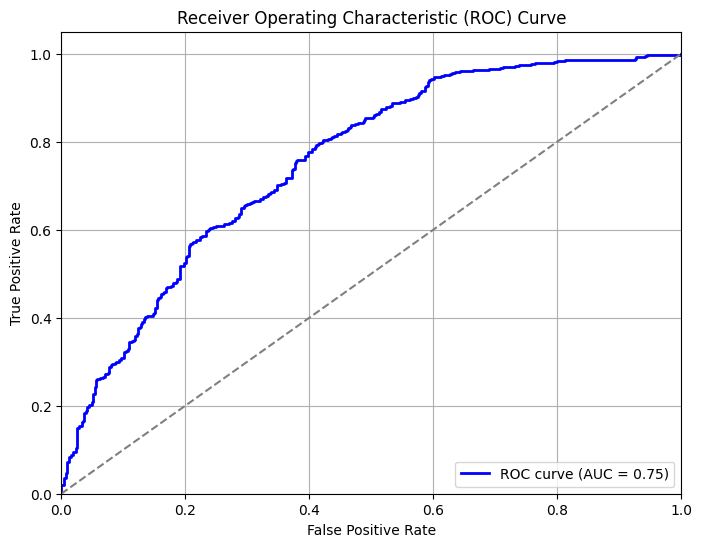

In [166]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [167]:
def evaluate_models(models, param_grids, X_train, X_test, y_train, y_test):
    """
    Evaluate multiple models using the evaluate_model_pipeline function and save the results in a dictionary.
    
    Args:
    - models: A dictionary of models where keys are model names and values are model objects.
    - param_grids: A dictionary of parameter grids corresponding to each model.
    - X_train: The training features.
    - X_test: The test features.
    - y_train: The training labels.
    - y_test: The test labels.
    
    Returns:
    - results: A dictionary containing evaluation results for each model.
    """
    results = {}
    for name, model in models.items():
        print(f"Evaluating {name}...")
        param_grid = param_grids[name]
        result = {}
        result['name'] = name
        result['params'] = tune_hyperparameters(model, param_grid, X_train, y_train)
        trained_model = train_model(model, result['params'], X_train, y_train)
        result['model'] = trained_model
        result['accuracy'], result['precision'], result['recall'], result['f1'], result['confusion_matrix'], result['fpr'], result['tpr'] = evaluate_model(trained_model, X_test, y_test)
        results[name] = result
    return results

## show result function

In [168]:
def plot_metrics_comparison(results):
    """
    Create a bar plot comparing evaluation metrics (Accuracy, Precision, Recall, F1-Score) for multiple models.
    
    Args:
    - results: A dictionary containing evaluation results for each model.
    """
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    model_names = list(results.keys())
    num_models = len(model_names)

    fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
    fig.suptitle('Comparison of Evaluation Metrics', fontsize=16)

    for i, metric in enumerate(metrics):
        for j, model_name in enumerate(model_names):
            metric_value = results[model_name][metric.lower()]
            axes[i].bar(j, metric_value, color=['blue', 'green', 'orange', 'red'][j])
        axes[i].set_ylabel(metric)
        axes[i].set_xticks(np.arange(num_models))
        axes[i].set_xticklabels(model_names, rotation=45)
        axes[i].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, X_test, y_test):
    """
    Plot and compare confusion matrices for multiple models.
    
    Args:
    - results: A dictionary containing evaluation results for each model.
    - X_test: The test features.
    - y_test: The test labels.
    """
    model_names = list(results.keys())

    for model_name in model_names:
        confusion_matrix = results[model_name]['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=np.unique(y_test))
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()

    
def plot_roc_auc(results, X_test, y_test):
    """
    plot
    
    Args:
    - results: A dictionary containing evaluation results for each model.
    - X_test: The test features.
    - y_test: The test labels.
    """
    model_names = list(results.keys())
    
    for model_name in model_names:
        fpr = results[model_name]['fpr']
        tpr = results[model_name]['tpr']
        
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{model_name}: (AUC = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## sample

In [33]:
# Load the breast cancer dataset
'''
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data
y = data.target
'''

'\nfrom sklearn.datasets import load_breast_cancer\n\ndata = load_breast_cancer()\nX = data.data\ny = data.target\n'

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Update models dictionary
models = {
    'RandomForest': RandomForestClassifier(),
    'DT': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(),
    'XGBoost': XGBClassifier()
}

# Update param_grids dictionary
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [5, 10]
    },
    'DT': {
        'min_samples_split': [2, 5],
        'min_samples_leaf': [5, 10]
    },
    'LogisticRegression': {
        'penalty': ['None', 'l2'],
        'C': [0.1, 1, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }
}

# Example usage:
results = evaluate_models(models, param_grids, X_train, X_test, y_train, y_test)

# Print results
for name, result in results.items():
    print(f"{name} - Best Parameters: {result['params']}")
    print(f"{name} - Accuracy: {result['accuracy']}")
    print(f"{name} - Precision: {result['precision']}")
    print(f"{name} - Recall: {result['recall']}")
    print(f"{name} - F1-Score: {result['f1']}")
    print(f"{name} - Confusion Matrix:\n{result['confusion_matrix']}\n")


Evaluating RandomForest...
Evaluating DT...
Evaluating LogisticRegression...


E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\sklearn\bas

Evaluating XGBoost...


ValueError: 
All the 90 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\sklearn.py", line 1500, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\core.py", line 1529, in __init__
    self._init(
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\core.py", line 1588, in _init
    it.reraise()
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\core.py", line 576, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\core.py", line 557, in _handle_exception
    return fn()
           ^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\data.py", line 1280, in next
    input_data(**self.kwargs)
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\core.py", line 624, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\data.py", line 1315, in _proxy_transform
    arr, feature_names, feature_types = _transform_pandas_df(
                                        ^^^^^^^^^^^^^^^^^^^^^
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\data.py", line 490, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "E:\005-freelancing\daneshkar\Class\Data Science and Machine Learning\001.ِData Science Project 2\venv_movie\Lib\site-packages\xgboost\data.py", line 308, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Action: object, Adventure: object, Animation: object, Comedy: object, Crime: object, Drama: object, Family: object, Fantasy: object, Horror: object, Mystery: object, Romance: object, Science Fiction: object, Thriller: object, other: object


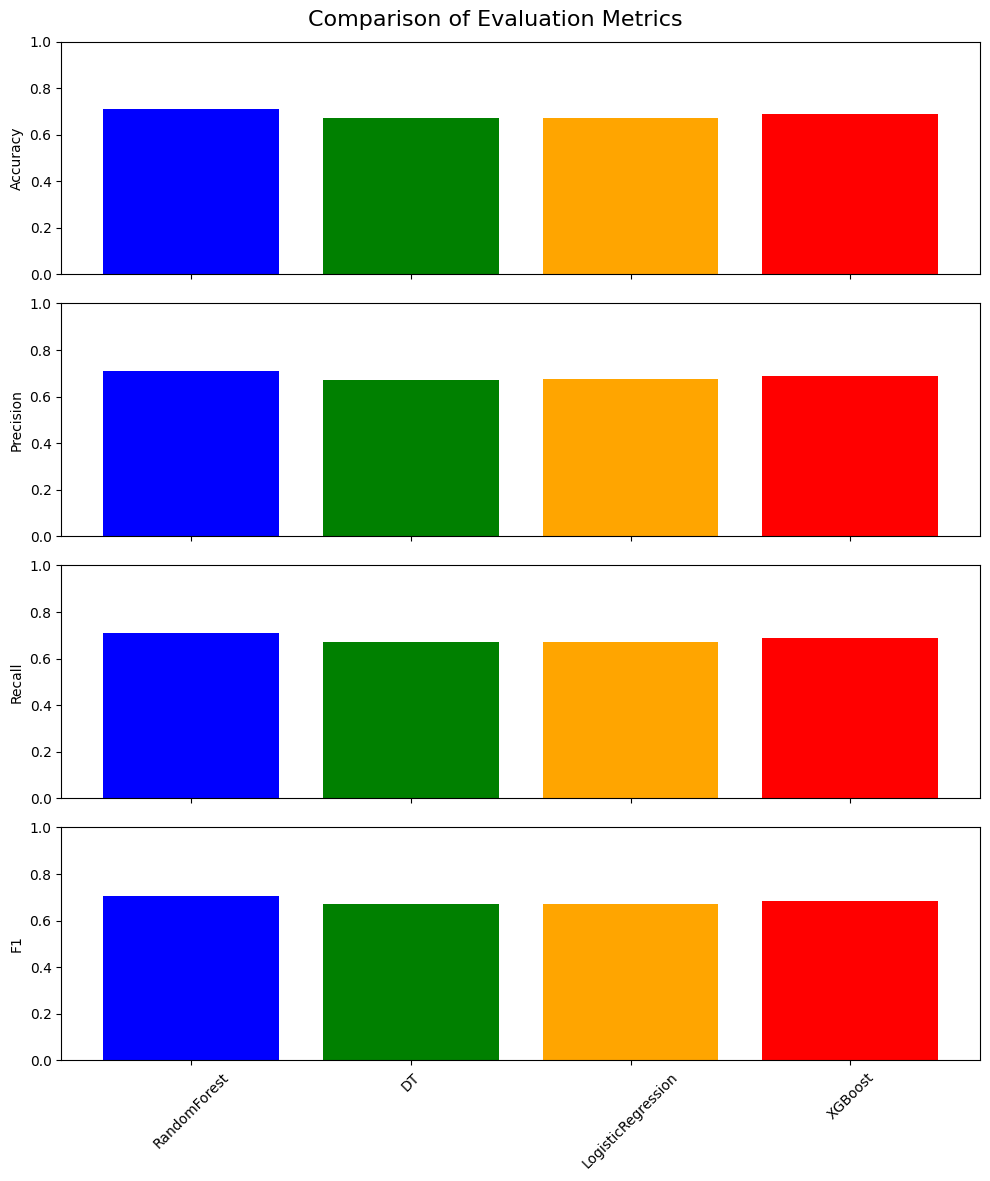

In [57]:
plot_metrics_comparison(results)

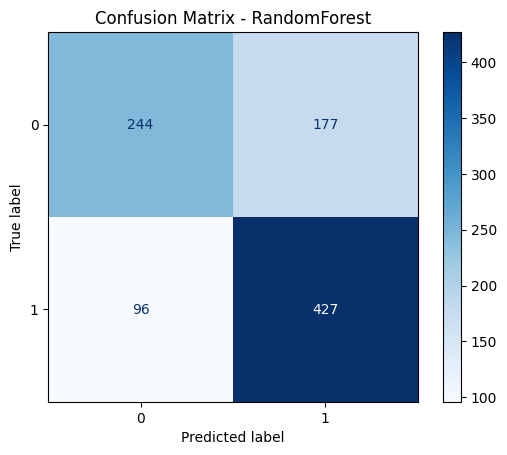

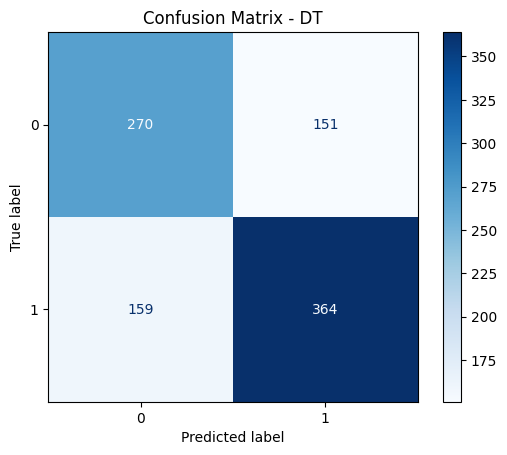

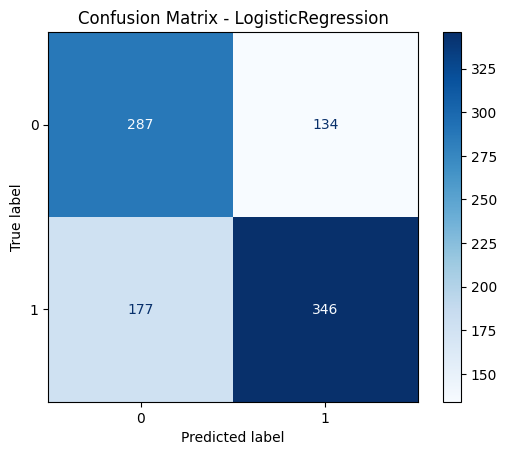

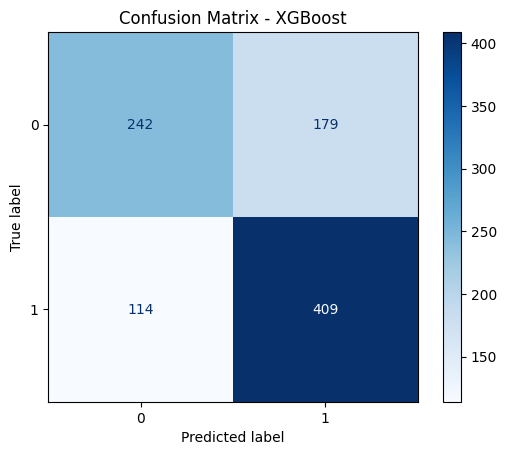

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


# Example usage:
plot_confusion_matrices(results, X_test, y_test)


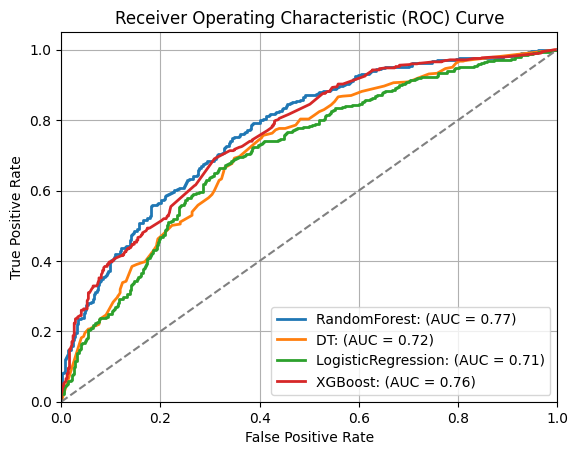

In [59]:


# Example usage:
plot_roc_auc(results, X_test, y_test)